# Modeling and Simulation in Python

Chapter 21

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### With air resistance

Next we'll add air resistance using the [drag equation](https://en.wikipedia.org/wiki/Drag_equation)

I'll start by getting the units we'll need from Pint.

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram

<Unit('kilogram')>

Now I'll create a `Params` object to contain the quantities we need.  Using a Params object is convenient for grouping the system parameters in a way that's easy to read (and double-check).

In [3]:
params = Params(height = 381 * m,
                v_init = 0 * m / s,
                g = 9.8 * m/s**2,
                mass = 2.5e-3 * kg,
                diameter = 19e-3 * m,
                rho = 1.2 * kg/m**3,
                v_term = 18 * m / s,
                t_end = 30 * s)

height                      381 meter
v_init             0.0 meter / second
g             9.8 meter / second ** 2
mass                  0.0025 kilogram
diameter                  0.019 meter
rho         1.2 kilogram / meter ** 3
v_term            18.0 meter / second
t_end                       30 second
dtype: object

Now we can pass the `Params` object `make_system` which computes some additional parameters and defines `init`.

`make_system` uses the given radius to compute `area` and the given `v_term` to compute the drag coefficient `C_d`.

In [4]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    unpack(params)
    
    init = State(y=height, v=v_init)
    area = np.pi * (diameter/2)**2
    C_d = 2 * mass * g / (rho * area * v_term**2)
    
    return System(params, init=init, area=area, C_d=C_d)

Let's make a `System`

In [5]:
system = make_system(params)

height                                              381 meter
v_init                                     0.0 meter / second
g                                     9.8 meter / second ** 2
mass                                          0.0025 kilogram
diameter                                          0.019 meter
rho                                 1.2 kilogram / meter ** 3
v_term                                    18.0 meter / second
t_end                                               30 second
init        y             381 meter
v    0.0 meter / secon...
area                         0.0002835287369864788 meter ** 2
C_d                          0.4445009981135434 dimensionless
dtype: object

Here's the slope function, including acceleration due to gravity and drag.

In [6]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object
    
    returns: derivatives of y and v
    """
    y, v = state
    unpack(system)
    
    f_drag = rho * v**2 * C_d * area / 2
    a_drag = f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag
    
    return dydt, dvdt

As always, let's test the slope function with the initial conditions.

In [7]:
slope_func(system.init, 0, system)

(<Quantity(0.0, 'meter / second')>, <Quantity(-9.8, 'meter / second ** 2')>)

We can use the same event function as last time.

In [8]:
def event_func(state, t, system):
    """Return the height of the penny above the sidewalk.
    """
    y, v = state
    return y

And then run the simulation.

In [9]:
results, details = run_ode_solver(system, slope_func, events=event_func)

A termination event occurred.


Here are the results.

In [10]:
results

y          v
0.000000   3.810000e+02   0.000000
0.000102   3.810000e+02  -0.001000
0.001122   3.810000e+02  -0.011000
0.011327   3.809994e+02  -0.110998
0.113367   3.809371e+02  -1.109588
1.133773   3.750650e+02  -9.886284
2.336542   3.593541e+02 -15.381283
3.679032   3.370777e+02 -17.358218
5.021521   3.133656e+02 -17.847263
6.657291   2.840359e+02 -17.971703
8.770202   2.460244e+02 -17.994545
11.635879  1.944437e+02 -17.996119
15.443329  1.258982e+02 -17.983647
18.300240  7.447803e+01 -17.988460
21.346191  1.965045e+01 -17.988046
22.439075 -7.105427e-15 -18.011550

The final height is close to 0, as expected.

Interestingly, the final velocity is not exactly terminal velocity, which suggests that there are some numerical errors.

We can get the flight time from `results`.

In [11]:
t_sidewalk = get_last_label(results)

22.439075231128985

Here's the plot of position as a function of time.

Saving figure to file figs/chap09-fig02.pdf


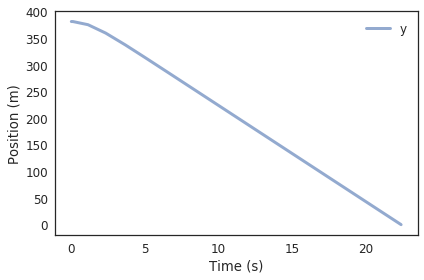

In [12]:
def plot_position(results):
    plot(results.y)
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')
    
plot_position(results)
savefig('figs/chap09-fig02.pdf')

And velocity as a function of time:

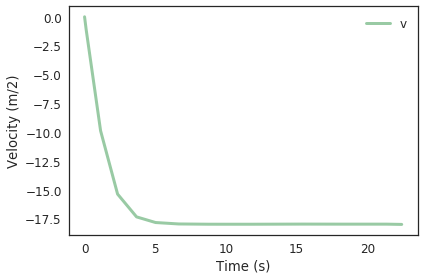

In [13]:
def plot_velocity(results):
    plot(results.v, color='C1', label='v')
        
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/2)')
    
plot_velocity(results)

From an initial velocity of 0, the penny accelerates downward until it reaches terminal velocity; after that, velocity is constant.

**Exercise:** Run the simulation with an initial velocity, downward, that exceeds the penny's terminal velocity.  Hint: you can modify an existing `Params` object like this:

`params.set(v_init = -30 * m / s)`


What do you expect to happen?  Plot velocity and position as a function of time, and see if they are consistent with your prediction.

In [14]:
# Solution

params.set(v_init = -30 * m / s)
system = make_system(params)
results, details = run_ode_solver(system, slope_func, events=event_func)

A termination event occurred.


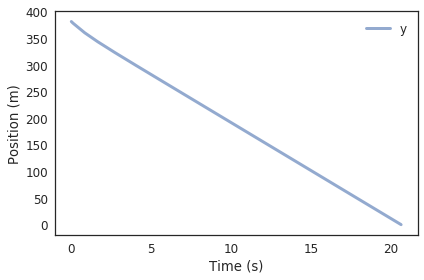

In [15]:
plot_position(results)

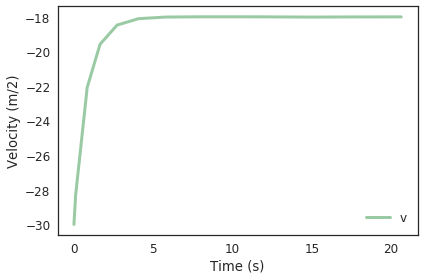

In [16]:
# Solution

plot_velocity(results)

### Exercises

**Exercise:** Suppose we drop a quarter from the Empire State Building and find that its flight time is 19.1 seconds.  Use this measurement and `fsolve` to estimate the terminal velocity.

1. You can get the relevant dimensions of a quarter from https://en.wikipedia.org/wiki/Quarter_(United_States_coin).

2. Create a `Params` object with the system parameters.  We don't know `v_term`, so we'll start with the inital guess `v_term = 18 * m / s`.

3. Use `make_system` to create a `System` object.

4. Call `run_ode_solver` to simulate the system.  How does the flight time of the simulation compare to the measurement?

5. Try a few different values of `t_term` and see if you can get the simulated flight time close to 19.1 seconds.

6. Optionally, write an error function and use `fsolve` to improve your estimate.

7. Use your best estimate of `v_term` to compute `C_d`.

Note: I fabricated the observed flight time, so don't take the results of this exercise too seriously.

In [17]:
# Solution

# Here's a `Params` object with the observed flight time and our initial guess for `v_term`

params = Params(height = 381 * m,
                v_init = 0 * m / s,
                g = 9.8 * m/s**2,
                mass = 5.67e-3 * kg,
                diameter = 24.26e-3 * m,
                rho = 1.2 * kg/m**3,
                v_term = 18 * m / s,
                flight_time = 19.1 * s,
                t_end = 30 * s)

height                         381 meter
v_init                0.0 meter / second
g                9.8 meter / second ** 2
mass                    0.00567 kilogram
diameter                   0.02426 meter
rho            1.2 kilogram / meter ** 3
v_term               18.0 meter / second
flight_time                  19.1 second
t_end                          30 second
dtype: object

In [18]:
# Solution

# Now we can make a `System` object

system = make_system(params)

height                                                 381 meter
v_init                                        0.0 meter / second
g                                        9.8 meter / second ** 2
mass                                            0.00567 kilogram
diameter                                           0.02426 meter
rho                                    1.2 kilogram / meter ** 3
v_term                                       18.0 meter / second
flight_time                                          19.1 second
t_end                                                  30 second
init           y             381 meter
v    0.0 meter / secon...
area                             0.000462244204111976 meter ** 2
C_d                             0.6183600157463346 dimensionless
dtype: object

In [19]:
# Solution

# And run the simulation

results, details = run_ode_solver(system, slope_func, events=event_func)
results

A termination event occurred.


y          v
0.000000   3.810000e+02   0.000000
0.000102   3.810000e+02  -0.001000
0.001122   3.810000e+02  -0.011000
0.011327   3.809994e+02  -0.110998
0.113367   3.809371e+02  -1.109588
1.133773   3.750650e+02  -9.886284
2.336542   3.593541e+02 -15.381283
3.679032   3.370777e+02 -17.358218
5.021521   3.133656e+02 -17.847263
6.657291   2.840359e+02 -17.971703
8.770202   2.460244e+02 -17.994545
11.635879  1.944437e+02 -17.996119
15.443329  1.258982e+02 -17.983647
18.300240  7.447803e+01 -17.988460
21.346191  1.965045e+01 -17.988046
22.439075 -1.776357e-14 -18.011550

In [20]:
# Solution

# And get the flight time

flight_time = get_last_label(results) * s

<Quantity(22.439075231128992, 'second')>

In [21]:
# Solution

# The flight time is a little long, so we could increase `v_term` and try again.

# Or we could write an error function

def error_func(v_term, params):
    """Final height as a function of C_d.
    
    C_d: drag coefficient
    params: Params object
    
    returns: height in m
    """
    params.set(v_term=v_term)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    flight_time = get_last_label(results) * s
    return flight_time - params.flight_time

In [22]:
# Solution

# We can test the error function like this

guess = 18 * m / s
error_func(guess, params)

A termination event occurred.


<Quantity(3.339075231128991, 'second')>

In [23]:
# Solution

# Now we can use `fsolve` to find the value of `v_term` that yields the measured flight time.

solution = fsolve(error_func, guess, params)

A termination event occurred.
A termination event occurred.
A termination event occurred.
A termination event occurred.
A termination event occurred.
A termination event occurred.
A termination event occurred.
A termination event occurred.
A termination event occurred.
A termination event occurred.
A termination event occurred.


array([21.68854346])

In [25]:
# Solution

# Plugging in the estimated value, we can use `make_system` to compute `C_d`

params.set(v_term=solution[0] * m/s)
system = make_system(params)
system.C_d

<Quantity(0.42591764806808585, 'dimensionless')>